# Food Delivery Operations Exploratory Data Analysis

In [1]:
# Importing Dataset from Kaggle

import kagglehub
Zomato_dataset = kagglehub.dataset_download('saurabhbadole/zomato-delivery-operations-analytics-dataset')

print('Data source import complete.')

Data source import complete.


In [31]:
# install required libraries

!pip install geopy
!pip install haversine
!pip install folium

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pandoc: filename=pandoc-2.4-py3-none-any.whl size=34821 sha256=6a38af03f7a322616212ee60bff30762649b0e2b93c802875212de83121a02db
  Stored in directory: c:\users\legion\appdata\local\pip\cache\wheels\9c\2f\9f\b1aac8c3e74b4ee327dc8c6eac5128996f9eadf586e2c0ba67
Successfully built pandoc


In [3]:
# Importing all the required libraries

import numpy as np
import pandas as pd
import os
import gc
from datetime import datetime
from datetime import date as dt
import geopy.distance
import gmplot

import warnings
warnings.simplefilter(action='ignore')

#Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sborn

#Geo coding libraries
from haversine import haversine, Unit
from sklearn.cluster import DBSCAN
import json
from geopy.geocoders import Nominatim
import time

#variables
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
TIME_FORMAT = '%H:%M'
DATE_FORMAT = '%d-%m-%Y'

In [4]:
# helper function/s

# calculate time difference
def get_timediff(t1:str, t2:str):
    
    '''
    get time difference between 2 time strings
    note: assumption is that t2 is always greater !
    '''
    try:
        t1 = datetime.strptime(t1, TIME_FORMAT)
        t2 = datetime.strptime(t2, TIME_FORMAT)
        if t2 > t1:
            subtractedTime = t2 - t1
            return int(subtractedTime.total_seconds() / 60)  # conver to mins
        else:
            return None
    except:
        return None
    

# calculate distance from geo-coordinates
def get_distance(rlat:float, rlon:float, dlat:float, dlon:float):
    
    '''
    get the distance (km) between 2 geo - coordinates
    note: the argument order does not change (restaurant > delivert loc.)
    '''
    # restaurant co-ordinates
    res_coords = (abs(rlat), abs(rlon))
    
    # delivery location co-ordinates
    dl_coords = (abs(dlat), abs(dlon))
    
    # get the distance
    try:
        dist = geopy.distance.geodesic(res_coords, dl_coords).km
        return round(dist,2)             # round to nearest 2 decimals
    except:
        return None

## Data Modelling and Cleaning

In [5]:
#import csv file as a pandas data frame along with date parsing for Order_date (optimization)

csv_file_path = os.path.join(Zomato_dataset, 'Zomato Dataset.csv')
dateparse = lambda x: datetime.strptime(x, DATE_FORMAT)
df = pd.read_csv(csv_file_path, parse_dates=['Order_Date'], date_parser=dateparse)

### Data cleaning operations

In [6]:
#drop rows with null values
df.dropna(inplace=True)

# renaming columns with spaces (to avoid data type errors)
df.rename(columns={'Time_taken (min)':'Time_taken_min'}, inplace=True)

# formatting column names -- optional
df.columns = [c.lower() for c in df.columns]
          
# sorting data for visualization
df.sort_values(by=['order_date'],inplace=True)
df.reset_index(drop=True, inplace=True)

print(f"Data Shape: {df.shape}\n\n")

Data Shape: (41359, 20)




In [7]:
# de-duplication criteria#1 columns 
dup_c1 = ['delivery_person_id'
       ,'delivery_person_age'
       #,'delivery_location_latitude'
       #,'delivery_location_longitude'
       ,'order_date'
       ,'time_orderd']

# de-duplicate the dataset (keep = None)
df = df[~df.duplicated(subset=dup_c1, keep=False)]

### convert age into INT ###  -- optional
df['delivery_person_age'] = df['delivery_person_age'].astype(np.int64)

### Rename attributes for better understanding
df.rename(columns={'time_orderd': 'time_ordered'}, inplace=True)
df.rename(columns={'id': 'order_id'}, inplace=True)
df.rename(columns={'delivery_person_ratings': 'order_rating'}, inplace=True)

### Removing illogical coordinate values (not corresponding to Indian mainland or any viable location)
df = df[(df['restaurant_latitude'] >= 10)].reset_index(drop=True)

In [8]:
df.head()

,order_id,delivery_person_id,delivery_person_age,order_rating,restaurant_latitude,restaurant_longitude,delivery_location_latitude,delivery_location_longitude,order_date,time_ordered,time_order_picked,weather_conditions,road_traffic_density,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city,time_taken_min
0,0xc47e,ALHRES07DEL01,22,4.1,25.449659,81.839744,25.459659,81.849744,2022-02-11,09:45,09:50,Windy,Low,0,Meal,motorcycle,0.0,No,Metropolitian,16
1,0xcff9,AURGRES13DEL02,24,5.0,19.880256,75.323503,19.930256,75.373503,2022-02-11,17:45,17:50,Cloudy,Medium,1,Buffet,motorcycle,1.0,No,Metropolitian,15
2,0xdef0,AURGRES12DEL01,34,4.8,19.879631,75.323403,19.919631,75.363403,2022-02-11,16:15,16:20,Windy,Medium,1,Snack,motorcycle,1.0,No,Metropolitian,34
3,0xbfcc,LUDHRES010DEL01,29,4.7,30.892860,75.822199,30.932860,75.862199,2022-02-11,15:40,15:50,Fog,Medium,2,Drinks,electric_scooter,0.0,No,Metropolitian,17
4,0xca87,KOLRES010DEL01,25,4.8,22.538999,88.322337,22.548999,88.332337,2022-02-11,11:10,11:25,Stormy,High,2,Meal,motorcycle,0.0,No,Metropolitian,20


### Data transformation Operations

### Restaurant Table

In [9]:
# Step 1: Create a unique DataFrame of restaurant locations
dfRestaurant_Dim = df[['restaurant_latitude', 'restaurant_longitude']].drop_duplicates().reset_index(drop=True)

# Step 2: Assign a unique ID
dfRestaurant_Dim['restaurant_id'] = range(1, len(dfRestaurant_Dim) + 1)

dfRestaurant_Dim.head()

,restaurant_latitude,restaurant_longitude,restaurant_id
0,25.449659,81.839744,1
1,19.880256,75.323503,2
2,19.879631,75.323403,3
3,30.892860,75.822199,4
4,22.538999,88.322337,5


### Delivery Location Table

In [10]:
# Step 1: Create a unique DataFrame of delivery locations
dfDeliveryLocation_Dim = df[['delivery_location_latitude', 'delivery_location_longitude']].drop_duplicates().reset_index(drop=True)

# Step 2: Assign a unique ID
dfDeliveryLocation_Dim['delivery_location_id'] = range(1, len(dfDeliveryLocation_Dim) + 1)

dfDeliveryLocation_Dim.head()

,delivery_location_latitude,delivery_location_longitude,delivery_location_id
0,25.459659,81.849744,1
1,19.930256,75.373503,2
2,19.919631,75.363403,3
3,30.932860,75.862199,4
4,22.548999,88.332337,5


### Order Details Table

In [11]:
# Step 1: Create a unique DataFrame of delivery associates
dfOrderDetails_Dim = df[['order_id', 'order_rating','order_date', 'time_ordered',
                         'time_order_picked', 'weather_conditions','road_traffic_density', 'vehicle_condition',
                         'type_of_order', 'type_of_vehicle','multiple_deliveries', 'festival','time_taken_min']].drop_duplicates().reset_index(drop=True)

dfOrderDetails_Dim.head()

,order_id,order_rating,order_date,time_ordered,time_order_picked,weather_conditions,road_traffic_density,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,time_taken_min
0,0xc47e,4.1,2022-02-11,09:45,09:50,Windy,Low,0,Meal,motorcycle,0.0,No,16
1,0xcff9,5.0,2022-02-11,17:45,17:50,Cloudy,Medium,1,Buffet,motorcycle,1.0,No,15
2,0xdef0,4.8,2022-02-11,16:15,16:20,Windy,Medium,1,Snack,motorcycle,1.0,No,34
3,0xbfcc,4.7,2022-02-11,15:40,15:50,Fog,Medium,2,Drinks,electric_scooter,0.0,No,17
4,0xca87,4.8,2022-02-11,11:10,11:25,Stormy,High,2,Meal,motorcycle,0.0,No,20


### Fact Table

In [12]:
# Step 1: Create a Fact table
dfOrder_Fact = df[['order_id','delivery_person_id',
                    'restaurant_latitude', 'restaurant_longitude',
                    'delivery_location_latitude', 'delivery_location_longitude']].drop_duplicates().reset_index(drop=True)

#Performing Left Join with Restaurant table to obtain surrogate key as foreign key
dfOrder_Fact = dfOrder_Fact.merge(
    dfRestaurant_Dim[['restaurant_id', 'restaurant_latitude', 'restaurant_longitude']],
    on=['restaurant_latitude', 'restaurant_longitude'],
    how='left'
)

#Performing Left Join with Delivery Location table to obtain surrogate key as foreign key
dfOrder_Fact = dfOrder_Fact.merge(
    dfDeliveryLocation_Dim[['delivery_location_id', 'delivery_location_latitude', 'delivery_location_longitude']],
    on=['delivery_location_latitude', 'delivery_location_longitude'],
    how='left'
)

# Cleaning up the fact table
dfOrder_Fact.drop(['restaurant_latitude', 'restaurant_longitude'], axis=1, inplace=True)
dfOrder_Fact.drop(['delivery_location_latitude', 'delivery_location_longitude'], axis=1, inplace=True)

dfOrder_Fact.head()

,order_id,delivery_person_id,restaurant_id,delivery_location_id
0,0xc47e,ALHRES07DEL01,1,1
1,0xcff9,AURGRES13DEL02,2,2
2,0xdef0,AURGRES12DEL01,3,3
3,0xbfcc,LUDHRES010DEL01,4,4
4,0xca87,KOLRES010DEL01,5,5


### Complete Dataset

In [13]:
#Initializing the complete dataframe
df = dfOrder_Fact

In [14]:
#Performing Left Join with Order Details Table
df = df.merge(dfOrderDetails_Dim, how='left', on='order_id')

#Performing Left Join with Restaurant Table
df = df.merge(dfRestaurant_Dim, how='left', on='restaurant_id')

#Performing Left Join with Delivery Location Table
df = df.merge(dfDeliveryLocation_Dim, how='left', on='delivery_location_id')

### Exporting all tables

In [15]:
dataframes = {
    'Fact Table': dfOrder_Fact,
    'Restaurant Table': dfRestaurant_Dim,
    'Order Details Table': dfOrderDetails_Dim,
    'Complete dataset': df
}

output_dir = "tables"
os.makedirs(output_dir, exist_ok=True)

for name, df1 in dataframes.items():
    df1.to_csv(os.path.join(output_dir, f'{name}.csv'), index=False)

## Visualizing restaurant locations and data clustering

### Initial Visulization

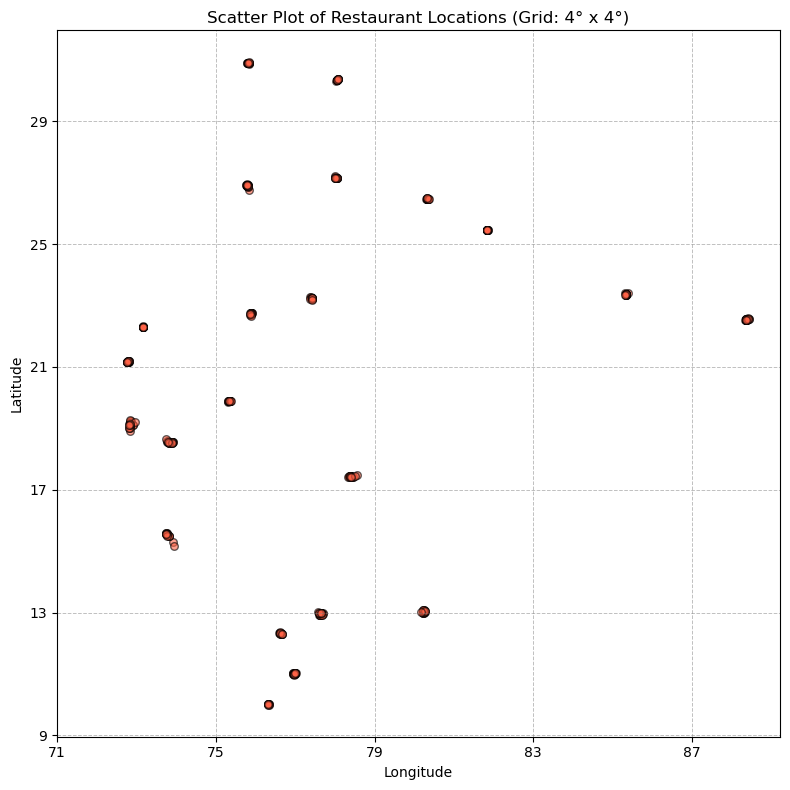

In [16]:
# Group by restaurant_id and count number of orders
df2 = df.groupby(['restaurant_id', 'restaurant_latitude', 'restaurant_longitude']).agg(total_orders=('restaurant_id', 'count')).reset_index()

# Create the figure
plt.figure(figsize=(8, 8))

# Scatter plot of restaurant locations
plt.scatter(df2['restaurant_longitude'], df2['restaurant_latitude'],
            alpha=0.6, edgecolor='black', color='tomato', s=30)

# Set axis labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Scatter Plot of Restaurant Locations (Grid: 4° x 4°)')

# Define grid spacing
lon_min, lon_max = df2['restaurant_longitude'].min(), df2['restaurant_longitude'].max()
lat_min, lat_max = df2['restaurant_latitude'].min(), df2['restaurant_latitude'].max()

# Set ticks for every 4 degrees
plt.xticks(range(int(lon_min)-1, int(lon_max)+2, 4))
plt.yticks(range(int(lat_min)-1, int(lat_max)+2, 4))

# Add vertical and horizontal gridlines at every 4 degrees
for x in range(int(lon_min)-1, int(lon_max)+2, 4):
    plt.axvline(x=x, color='gray', linestyle='--', linewidth=0.7, alpha=0.5)
for y in range(int(lat_min)-1, int(lat_max)+2, 4):
    plt.axhline(y=y, color='gray', linestyle='--', linewidth=0.7, alpha=0.5)

# Add custom grid
plt.grid(False)
plt.tight_layout()
plt.show()


In [17]:
# Load your dataset
coords = df2[['restaurant_latitude', 'restaurant_longitude']].values

# Haversine distance function returns distance in kilometers
def haversine_distance_matrix(locations):
    n = len(locations)
    matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            matrix[i, j] = haversine(locations[i], locations[j], unit=Unit.KILOMETERS)
    return matrix

# Step 1: Convert lat/lon to radians for DBSCAN with haversine
coords_radians = np.radians(coords)

# Step 2: Run DBSCAN clustering
# 30 km radius city ⇒ epsilon = 30 km (converted to radians)
kms_per_radian = 6371.0088
epsilon = 30 / kms_per_radian  # radius in radians

db = DBSCAN(eps=epsilon, min_samples=5, algorithm='ball_tree', metric='haversine').fit(coords_radians)
df2['city_label'] = db.labels_  # -1 means noise

# Step 3: Preview city-labeled data
print(df2[['restaurant_latitude', 'restaurant_longitude', 'city_label']].head())

# Optional: Save labeled data
df2.to_csv("City Tables.csv", index=False)


   restaurant_latitude  restaurant_longitude  city_label
0            25.449659             81.839744           0
1            19.880256             75.323503           1
2            19.879631             75.323403           1
3            30.892860             75.822199           2
4            22.538999             88.322337           3


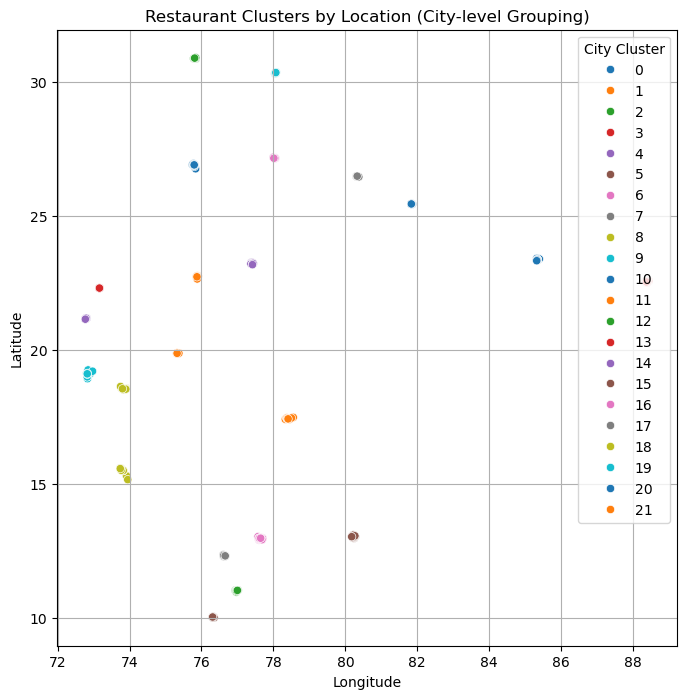

In [18]:
# Basic scatter plot with clusters
plt.figure(figsize=(8, 8))
sborn.scatterplot(
    data=df2,
    x='restaurant_longitude',
    y='restaurant_latitude',
    hue='city_label',
    palette='tab10',
    legend='full'
)
plt.title("Restaurant Clusters by Location (City-level Grouping)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title='City Cluster')
plt.grid(True)
plt.show()


### Setting up cache with Geolocation

In [19]:
# Load or initialize cache
if os.path.exists("geocoding_cache.json"):
    with open("geocoding_cache.json", "r") as f:
        geocoding_cache = json.load(f)
else:
    geocoding_cache = {}

# Compute cluster centers using median
cluster_centers = df2.groupby('city_label')[['restaurant_latitude', 'restaurant_longitude']].median().reset_index()

# Initialize geolocator
geolocator = Nominatim(user_agent="geoapi")

def fun_coord_key(lat, lon):
    return f"{round(lat, 5)},{round(lon, 5)}"

def get_city_name_with_fallback(cluster_label, lat, lon, df_clustered):
    key = fun_coord_key(lat, lon)
    
    # Return from cache if available
    if key in geocoding_cache:
        # print(f"[CACHE HIT] {key} → {geocoding_cache[key]}")
        return geocoding_cache[key]
    
    print(f"[CACHE MISS] {key} → making API call...")
    
    # Try reverse geocoding on center
    try:
        location = geolocator.reverse((lat, lon), exactly_one=True, timeout=10)
        if location and 'address' in location.raw:
            city = location.raw['address'].get('city') or \
                   location.raw['address'].get('town') or \
                   location.raw['address'].get('state')
            if city:
                geocoding_cache[key] = city
                return city
    except Exception as e:
        print(f"[ERROR] Reverse geocoding failed for center: {e}")
    
    # Fallback: iterate through other coordinates in the cluster
    group = df_clustered[df_clustered['city_label'] == cluster_label]
    for _, row in group.iterrows():
        coord_key = fun_coord_key(row['restaurant_latitude'], row['restaurant_longitude'])
        if coord_key in geocoding_cache:
            return geocoding_cache[coord_key]
        try:
            location = geolocator.reverse(
                (row['restaurant_latitude'], row['restaurant_longitude']),
                exactly_one=True,
                timeout=10
            )
            if location and 'address' in location.raw:
                city = location.raw['address'].get('city') or \
                       location.raw['address'].get('town')
                if city:
                    geocoding_cache[coord_key] = city
                    return city
        except Exception as e:
            print(f"[FALLBACK ERROR] {coord_key}: {e}")
        time.sleep(1)  # Respect API limits
    
    geocoding_cache[key] = "Unknown"
    return "Unknown"

# Apply the function to cluster centers
cluster_centers['city_name'] = cluster_centers.apply(
    lambda row: get_city_name_with_fallback(
        cluster_label=row['city_label'],
        lat=row['restaurant_latitude'],
        lon=row['restaurant_longitude'],
        df_clustered=df2
    ),
    axis=1
)

with open("geocoding_cache.json", "w") as f:
    json.dump(geocoding_cache, f, indent=2)

# Drop city_name if it exists in df2
if 'city_name' in df2.columns:
    df2 = df2.drop(columns=['city_name'])

# Then merge
df2 = df2.merge(
    cluster_centers[['city_label', 'city_name']],
    on='city_label',
    how='left'
)

In [20]:
print(f"Loaded {len(geocoding_cache)} cached coordinates.")

# Leftjoin to add data to the working dataframe
df = df.merge(df2[['restaurant_id','city_label','city_name']],
              on='restaurant_id',
              how='left'
    )

# Output the city label dataframe
output_dir = "tables"
os.makedirs(output_dir, exist_ok=True)          # 1) ensure the folder exists

file_name = "City Table.csv"                    # 2) give the file a real name
df2.to_csv(os.path.join(output_dir, file_name), index=False)

Loaded 24 cached coordinates.


### Map visualization

In [21]:
import folium

# Step 1: Cluster summary
cluster_stats = df2.groupby('city_name').agg({
    'restaurant_latitude': 'median',
    'restaurant_longitude': 'median',
    'restaurant_id': pd.Series.nunique
}).reset_index().rename(columns={'restaurant_id': 'restaurant_count'})

# Step 2: Base map centered over India
fmap = folium.Map(
    location=[
        cluster_stats['restaurant_latitude'].mean(),
        cluster_stats['restaurant_longitude'].mean()
    ],
    zoom_start=5,
    tiles='CartoDB Positron'  # Cleaner look
)

# Step 3: Plot circles
for _, row in cluster_stats.iterrows():
    lat = row['restaurant_latitude']
    lon = row['restaurant_longitude']
    city = row['city_name']
    count = row['restaurant_count']

    radius = 12000 * np.sqrt(count)
    font_size = min(108, 10 + int(np.sqrt(count)))  # Cap max size for clarity

    # Circle for the cluster
    folium.Circle(
        location=[lat, lon],
        radius=radius,
        color='Green',
        fill=True,
        fill_opacity=0.4
    ).add_to(fmap)

    # Label: restaurant count (center of circle)
    folium.Marker(
        location=[lat, lon],
        icon=folium.DivIcon(html=f"""
            <div style="text-align: center;">
                <span style="
                    font-size: {font_size}px;
                    font-weight: bold;
                    color: black;
                    line-height: 1;
                ">{count}</span>
            </div>
        """)
    ).add_to(fmap)

    # Label: city name (below circle)
    folium.Marker(
        location=[lat - 0.1 * np.sqrt(count), lon],  # shift slightly downward (tweak 0.2 as needed)
        icon=folium.DivIcon(html=f"""
            <div style="text-align: center;">
                <span style="
                    font-size: {font_size - 2}px;
                    font-weight: normal;
                    color: grey;
                ">{city}</span>
            </div>
        """)
    ).add_to(fmap)



# Step 4: Save or display
fmap.save("zomato_clusters_folium.html")

# If in notebook:
from IPython.display import IFrame
IFrame("zomato_clusters_folium.html", width=900, height=600)


## Insights from the data

### Q1. What is the average delivery time per city ?

In [22]:
avg_time_by_city = (
    df
    .groupby('city_name', as_index=False)['time_taken_min']
    .mean()
    .rename(columns={'time_taken_min': 'avg_delivery_min'})
    .sort_values('avg_delivery_min')
)


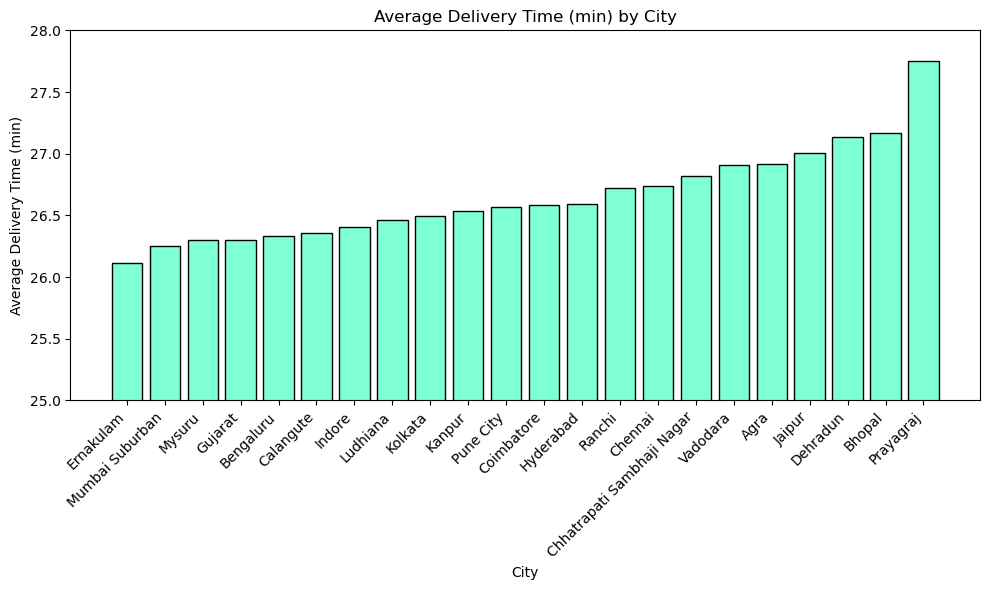

In [23]:
fig, ax1 = plt.subplots(figsize=(10, 6))

bars = ax1.bar(avg_time_by_city['city_name'], avg_time_by_city['avg_delivery_min'],
               color='aquamarine', label='Average Delivery Time', edgecolor='black')
ax1.set_ylim(25,28)
ax1.set_ylabel('Average Delivery Time (min)')
ax1.set_xlabel('City')
ax1.tick_params(axis='y')
ax1.set_xticklabels(avg_time_by_city['city_name'], rotation=45, ha='right')

plt.title('Average Delivery Time (min) by City')
plt.tight_layout()
plt.show()

### Q2. What is the order volume for each city ?

In [24]:
order_volume_by_city = (
    df
    .groupby('city_name', as_index=False)['order_id']
    .count()
    .rename(columns={'order_id': 'count_of_orders'})
    .sort_values('count_of_orders', ascending=True)
)

total_orders = order_volume_by_city['count_of_orders'].sum()

order_volume_by_city['percent_of_total'] = (
    order_volume_by_city['count_of_orders'] / total_orders * 100
)

order_volume_by_city['percent_of_total'] = order_volume_by_city['percent_of_total'].round(1)

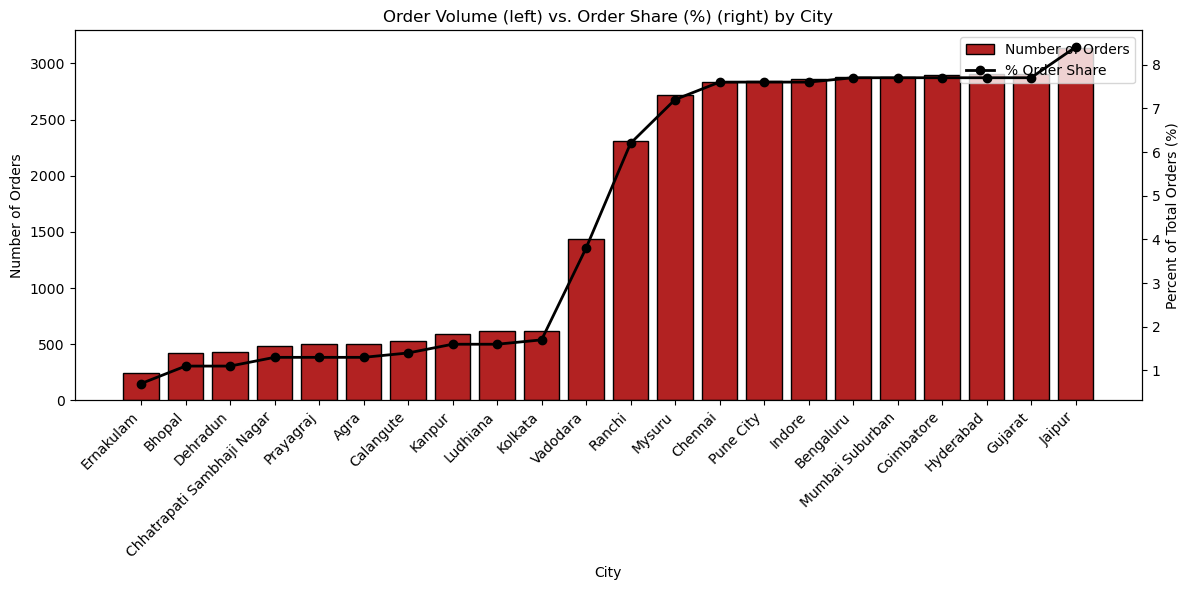

In [25]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Left Y‑axis: number of orders (bar chart)
bars = ax1.bar(order_volume_by_city['city_name'], order_volume_by_city['count_of_orders'],
               color='firebrick', label='Number of Orders',
               edgecolor='black')
ax1.set_ylabel('Number of Orders')
ax1.set_xlabel('City')
ax1.tick_params(axis='y')
ax1.set_xticklabels(order_volume_by_city['city_name'], rotation=45, ha='right')

# Right Y‑axis: % of total orders (line chart)
ax2 = ax1.twinx()
line = ax2.plot(order_volume_by_city['city_name'], order_volume_by_city['percent_of_total'],
                 color='black', marker='o', linewidth=2, label='% Order Share')
ax2.set_ylabel('Percent of Total Orders (%)')
ax2.tick_params(axis='y')

# Combine legends
handles, labels = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles + handles2, labels + labels2, loc='upper right')

plt.title('Order Volume (left) vs. Order Share (%) (right) by City')
plt.tight_layout()
plt.show()

### Q3. How did each city perform in terms of customer satisfaction ?

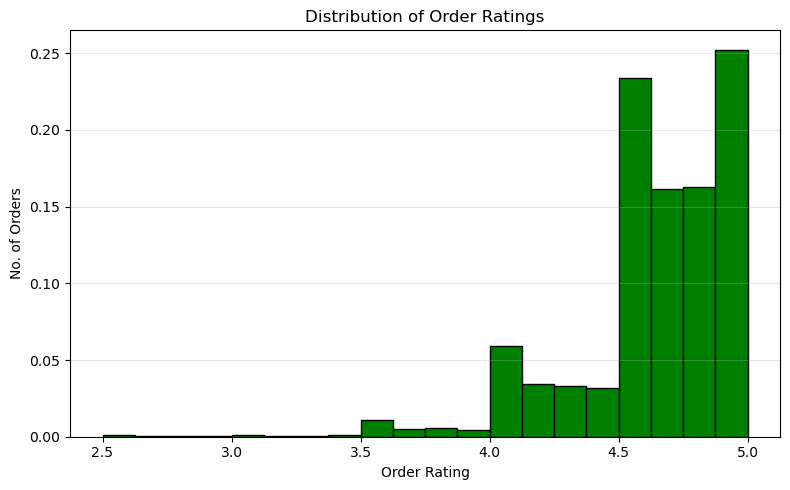

In [26]:
ratings = df['order_rating'].dropna()
n = len(ratings)

weights = np.ones_like(ratings) / n

plt.figure(figsize=(8, 5))
plt.hist(ratings,
         bins=20,
         weights=weights,                          
         color='green',
         edgecolor='black')

plt.xlabel('Order Rating')
plt.ylabel('No. of Orders')
plt.title('Distribution of Order Ratings')
# plt.xticks(np.arange(np.floor(ratings.min()*10)/10,
#                      np.ceil(ratings.max()*10)/10 + 0.1, 0.1),
#            rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

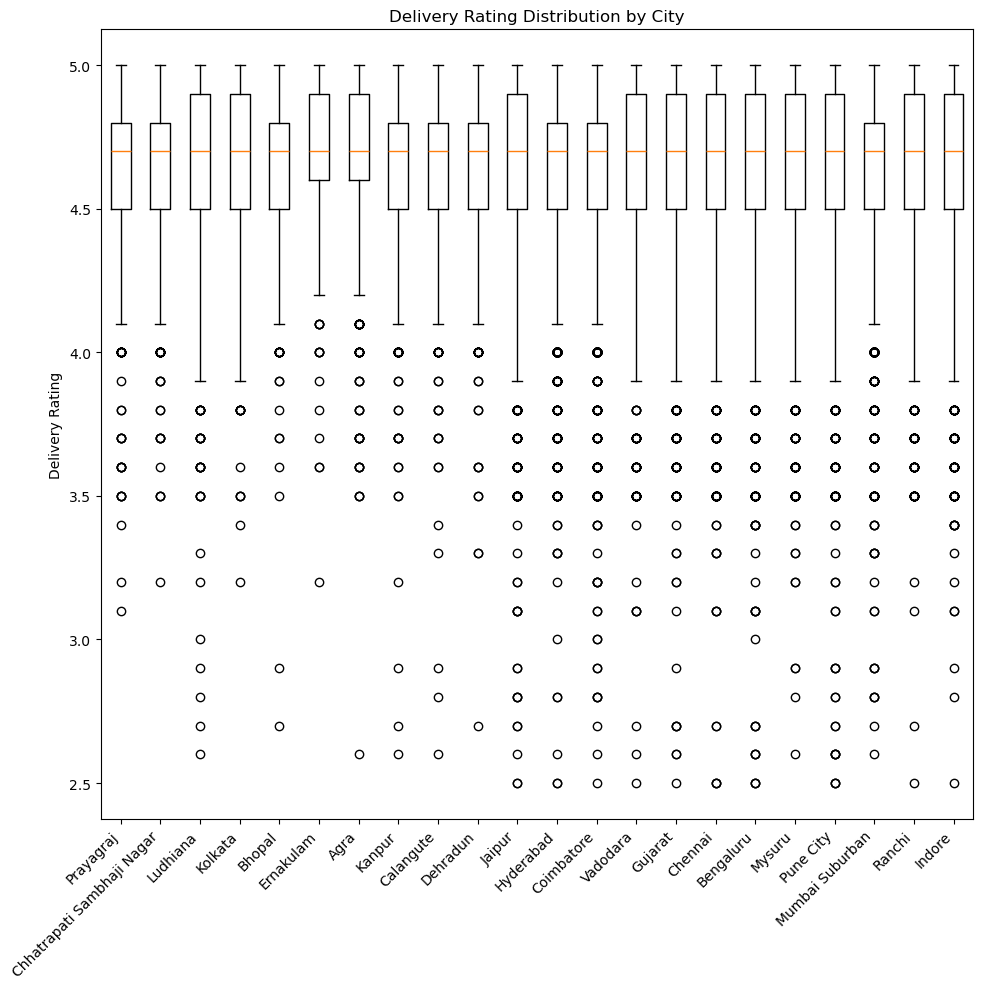

In [27]:
import matplotlib.pyplot as plt

cities = df['city_name'].unique()
box_data = [
    df.loc[df['city_name'] == city, 'order_rating'].dropna()
    for city in cities
]

plt.figure(figsize=(10, 10))
plt.boxplot(box_data, labels=cities, vert=True)

plt.ylabel('Delivery Rating')
plt.title('Delivery Rating Distribution by City')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [28]:
# 1) Compute Q1, Q3, IQR and lower bound for each city
quartile_stats = (
    df.groupby('city_name')['order_rating']
       .agg(q1=lambda x: x.quantile(0.25),
            q3=lambda x: x.quantile(0.75))
       .assign(iqr=lambda d: d['q3'] - d['q1'],
               lower_bound=lambda d: d['q1'] - 1.5 * d['iqr'])
       .reset_index()
)

# 2) Join these bounds back to every row
df_with_bounds = df.merge(
    quartile_stats[['city_name', 'lower_bound']], on='city_name', how='left'
)

# 3) Obtain only outlier entries
df_with_bounds = df_with_bounds[
     df_with_bounds['order_rating']< df_with_bounds['lower_bound']
]

print(f"Data Shape: {df_with_bounds.shape}")
print(f"Data Shape: {df.shape}")

Data Shape: (1399, 23)
Data Shape: (37527, 22)


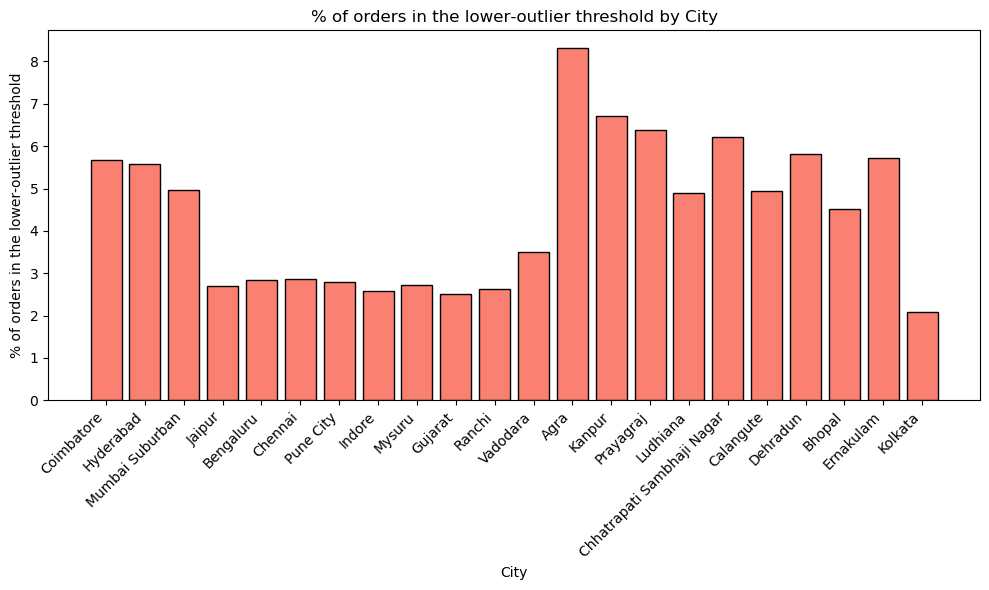

In [29]:
# 2) Count outliers per city
outlier_counts = (
    df_with_bounds.groupby('city_name')
            .size()
            .sort_values(ascending=False)      
            .reset_index(name='outlier_count')
)

outlier_counts = outlier_counts.merge(
    order_volume_by_city[['count_of_orders','city_name']],
    on='city_name',
    how="left"
)

outlier_counts['fraction_of_outliers'] = (outlier_counts['outlier_count']*100/outlier_counts['count_of_orders'])

# 3) Bar plot
plt.figure(figsize=(10, 6))
plt.bar(outlier_counts['city_name'], outlier_counts['fraction_of_outliers'], color='salmon', edgecolor='black')

plt.ylabel('% of orders in the lower‑outlier threshold')
plt.xlabel('City')
plt.title('% of orders in the lower‑outlier threshold by City')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [30]:
outlier_counts = outlier_counts.sort_values('fraction_of_outliers', ascending=False)

print(outlier_counts[['city_name', 'fraction_of_outliers', 'outlier_count']].head(7))

                     city_name  fraction_of_outliers  outlier_count
12                        Agra              8.316832             42
13                      Kanpur              6.722689             40
14                   Prayagraj              6.374502             32
16  Chhatrapati Sambhaji Nagar              6.211180             30
18                    Dehradun              5.813953             25
20                   Ernakulam              5.714286             14
0                   Coimbatore              5.662983            164
